# Find true amplification of freshwater fluxes

To test that linear response theory is recovering the true amplification of freshwater fluxes, we need to evaluate the amplification of fluxes from CESM flux fields. Note that as linear response theory is finding the change in freshwater fluxes as a proportion of the FAFMIP perturbation, the truth is not exactly the change in magnitude of freshwater fluxes. Here we show the test with the integration metric defined in the paper


This notebook is comparable to true_freshwater_fluxes_integration.ipynb except updated as of September 2023 to use the linear trend way of calculating the response instead of the last 5 years minus first 5 years

In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe

In [2]:
#First, load in all the freshwater fluxes. See notebook processing_salt_fluxes.py for how to generate the files that we unpickle here
#NOTE THESE FILES WERE TOO BIG TO PUT ON GIT. you have to rerun processing_salt_fluxes.py to make these yourself (or email me)


import pickle
with open("/scratch/abf376/freshwater_flux_linresp/model_tests/pickled_files_regriddedobjects/regridded_salt_flux_historical", "rb") as fp:   #Unpickling, replace string with drectory where pickled file lives
    regridded=pickle.load(fp)
    

with open("/scratch/abf376/freshwater_flux_linresp/model_tests/pickled_files_regriddedobjects/regridded_salt_flux_2005on", "rb") as fp:   #Unpickling
    regridded_2005on=pickle.load(fp)

## First we calculate the true fluxes for the ensemble mean

In [3]:
#average over ensemble member
salt_flux_avg_pre2005=sum(regridded)/34
salt_flux_avg_pre2005=salt_flux_avg_pre2005.rename({'y': 'latitude','x': 'longitude'})
salt_flux_avg_pre2005=salt_flux_avg_pre2005.assign_coords(latitude=salt_flux_avg_pre2005.lat[:,0],longitude=salt_flux_avg_pre2005.lon[0,:])

salt_flux_avg_2005on=sum(regridded_2005on)/34
salt_flux_avg_2005on=salt_flux_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
salt_flux_avg_2005on=salt_flux_avg_2005on.assign_coords(latitude=salt_flux_avg_2005on.lat[:,0],longitude=salt_flux_avg_2005on.lon[0,:])

In [4]:
salt_avg=xr.concat([salt_flux_avg_pre2005,salt_flux_avg_2005on],dim="time") #concatenate so now this is from 1920 to 2080
salt_flux_avg_1970to2019=salt_avg[12*50:12*100,:,:] #salt_avg was from 1920 to 2080 so this is from 1970 to 2019
a=np.linspace(1920,2080,161)
#print(a[50:100])

climatological_salt_flux=salt_avg[0:12*55,:,:].mean('time') #this is 1920 to 1975

In [5]:
#create area grid

import sys
sys.path.insert(1, '/scratch/abf376/')
from area_grid import *

area=area_grid(latitudes=np.array(salt_flux_avg_pre2005[0,:,:].latitude),longitudes=salt_flux_avg_pre2005[0,:,:].longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[salt_flux_avg_pre2005[0,:,:].latitude,salt_flux_avg_pre2005[0,:,:].longitude])

In [6]:
#water flux from fafmip
f='/scratch/abf376/FAFMIP_wfo_v2.nc' 
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
wfo = xr.open_dataset(f)['water_flux_into_sea_water']
wfo=wfo.where(wfo<1E19)


area_wfo=area_grid(latitudes=np.array(wfo.latitude),longitudes=wfo.longitude)
area_wfo=xr.DataArray(area,dims=["latitude","longitude"],coords=[wfo.latitude,wfo.longitude])

In [7]:
A=((np.abs(wfo.mean('time')))*area_wfo.where(area_wfo.latitude<65)).sum() #strength of wfo in this way, 9.99660706e+08 if calculated with regridded or 1.08156723e+09 if not calculated with regridded


In [8]:
#regrid wfo (FAFMIP flux)
ds_out = xe.util.grid_global(1, 1)
regridder_wfo= xe.Regridder(wfo, ds_out, "bilinear",periodic=True)
wfo = regridder_wfo(wfo)
wfo=wfo.rename({'y': 'latitude','x': 'longitude'})
wfo=wfo.assign_coords(latitude=wfo.lat[:,0],longitude=wfo.lon[0,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [9]:
EP_pattern_wfo=np.empty(50)
for i in range(0,50):
    EP_pattern_wfo[i]=np.abs((((salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')).where(np.sign(wfo.mean('time'))>0))*area.where(area.latitude<65)).sum())+np.abs((((salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')).where(np.sign(wfo.mean('time'))<0))*area.where(area.latitude<65)).sum())

In [19]:
np.random.seed(0)
A=((np.abs(wfo.mean('time')))*area.where(area.latitude<65)).sum() #strength of wfo in this way, 9.99660706e+08 if calculated with regridded or 1.08156723e+09 if not calculated with regridded

p=scipy.stats.linregress(np.linspace(0,44,45), y=EP_pattern_wfo[5:50]/np.array(A), alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)
change2=np.empty([3000])
individual_variance2=np.empty([3000]) #this saves the individual variance of each new linear trend so that we can account for that in the error bars if we want


from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 3000

y_star_cb \
    = circular_block_bootstrap(EP_pattern_wfo[5:50]/np.array(A)-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=bootstrap[i], alternative='two-sided')
    change2[i]=(p.intercept+p.slope*np.linspace(0,44,45))[-1]-(p.intercept+p.slope*np.linspace(0,44,45))[0]
    individual_variance2[i]=(p.stderr*45)**2


print(change2.mean())
print(change2.std())
print(np.sqrt((individual_variance2+change2**2).mean()-(change2.mean())**2)) #error bars accounting for spread of new trends and the variance of each newly fitted trend 

0.41141399461839356
0.04529299611834464
0.06023418556863262


Text(0, 0.5, 'P(t)')

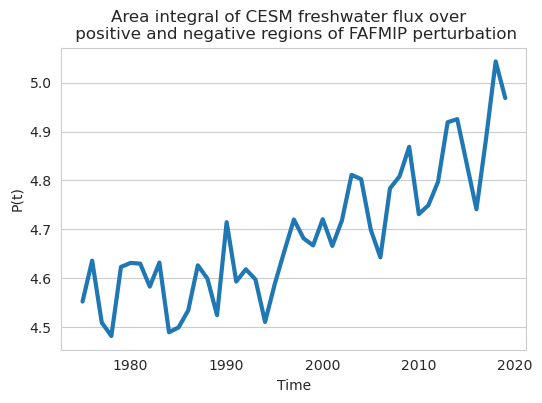

In [14]:
import matplotlib as mpl
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig, ax = plt.subplots()
mpl.rcParams['figure.dpi'] = 100
plt.plot(np.linspace(1975,2019,45),EP_pattern_wfo[5:50]/np.array(A),linewidth=3)
#plt.plot(np.linspace(1975,2019,45),slope*(np.linspace(1975,2019,45))+intercept)
ax.xaxis.grid()
plt.xlabel('Time')
plt.title('Area integral of CESM freshwater flux over  \n positive and negative regions of FAFMIP perturbation')
plt.ylabel('P(t)')
#mpl.pyplot.savefig('P(t)_CESM_ensemblemean_int', dpi=300,bbox_inches='tight')

## Let's plot what we're actually looking at here

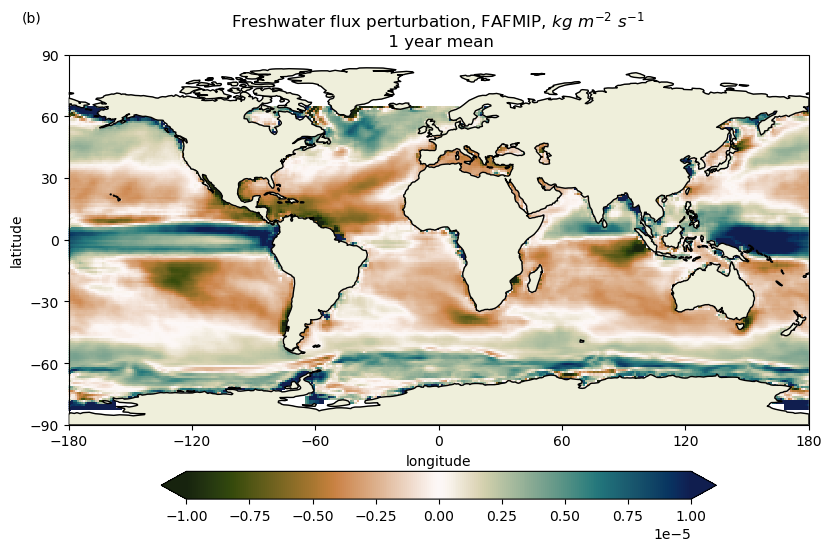

In [11]:
import cmocean
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(wfo.mean('time')).where((wfo[0,:,:].latitude<65)).plot(cmap=cmocean.cm.tarn,vmax=1E-5,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Freshwater flux perturbation, FAFMIP, $kg \ m^{-2} \ s^{-1}$ \n 1 year mean')
ax.text(-0.05, 1.10, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
fig.tight_layout()
mpl.pyplot.savefig('freshwater_flux_FAFMIP.png', dpi=300,bbox_inches='tight',facecolor='white',transparent=False)

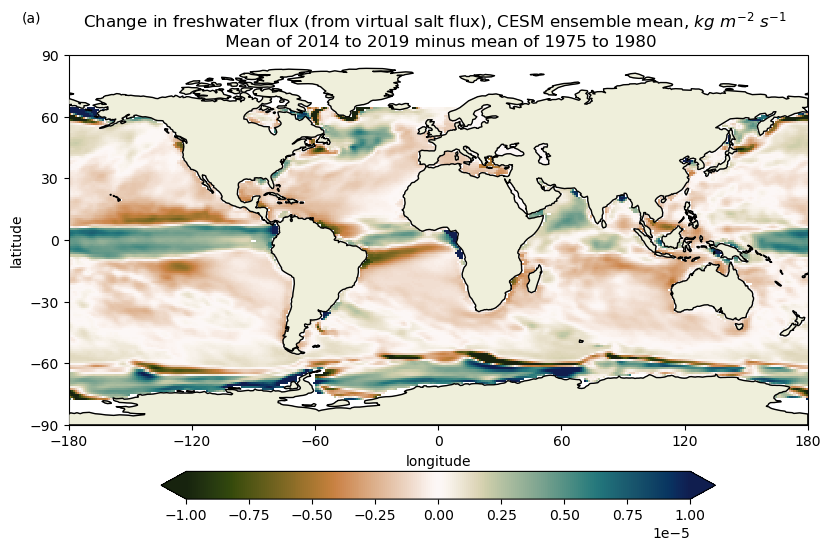

In [12]:
import cmocean
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(salt_flux_avg_1970to2019[45*12:50*12,:,:].mean('time')-salt_flux_avg_1970to2019[5*12:10*12,:,:].mean('time')).where(salt_flux_avg_pre2005[0,:,:].latitude<65).plot(cmap=cmocean.cm.tarn,vmax=1E-5,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax.text(-0.05, 1.10, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.title('Change in freshwater flux (from virtual salt flux), CESM ensemble mean, $kg \ m^{-2} \ s^{-1}$  \n Mean of 2014 to 2019 minus mean of 1975 to 1980')
fig.tight_layout()
mpl.pyplot.savefig('freshwater_flux_CESM.png', dpi=300,bbox_inches='tight',facecolor='white',transparent=False)

## Now, we need to do the same for each individual member

In [11]:
# a list of all ensemble members
for i in range(0,34):
    regridded[i]=regridded[i].rename({'y': 'latitude','x': 'longitude'})
    regridded[i]=regridded[i].assign_coords(latitude=salt_flux_avg_pre2005.latitude,longitude=salt_flux_avg_pre2005.longitude)
    
    regridded_2005on[i]=regridded_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    regridded_2005on[i]=regridded_2005on[i].assign_coords(latitude=salt_flux_avg_pre2005.latitude,longitude=salt_flux_avg_pre2005.longitude)
    
salt_avg_list=[]
for i in range(0,34):
    salt_avg_list.append(xr.concat([regridded[i],regridded_2005on[i]],dim="time"))
    
climatological_salt_flux_list=[]
for i in range(0,34):
    climatological_salt_flux_list.append(salt_avg_list[i][0:12*55,:,:].mean('time')) #this is 1920 to 1975
    salt_avg_list[i]=salt_avg_list[i][12*50:12*100,:,:]

In [12]:
EP_pattern_wfo_list=np.empty([34,50])
for j in range(0,34):
    for i in range(0,50):
        EP_pattern_wfo_list[j,i]=np.abs((((salt_avg_list[j][i*12:(i+1)*12,:,:].mean('time')).where(np.sign(wfo.mean('time'))>0))*area.where(area.latitude<65)).sum())+np.abs((((salt_avg_list[j][i*12:(i+1)*12,:,:].mean('time')).where(np.sign(wfo.mean('time'))<0))*area.where(area.latitude<65)).sum())

In [13]:
pval_store=np.empty(34)
np.random.seed(0)
A=((np.abs(wfo.mean('time')))*area.where(area.latitude<65)).sum() #strength of wfo in this way, 9.99660706e+08 if calculated with regridded or 1.08156723e+09 if not calculated with regridded

change=np.empty([3000,34])
individual_variance=np.empty([3000,34])
for j in range(0,34):
    trend=np.empty([45])
    p=scipy.stats.linregress(np.linspace(0,44,45), y=EP_pattern_wfo_list[j,5:50]/np.array(A), alternative='two-sided')
    trend=p.intercept+p.slope*np.linspace(0,44,45)
    pval_store[j]=p.pvalue

    from recombinator.block_bootstrap import circular_block_bootstrap

    # number of replications for bootstraps (number of resampled time-series to generate)
    B = 3000

    y_star_cb \
        = circular_block_bootstrap(EP_pattern_wfo_list[j,5:50]/np.array(A)-trend, 
                                   block_length=3, 
                                   replications=B, replace=True)
    bootstrap=[]
    for i in range(0,B):
        bootstrap.append(trend+y_star_cb[i,:])

    for i in range(0,B):
        p=scipy.stats.linregress(np.linspace(0,44,45), y=bootstrap[i], alternative='two-sided')
        change[i,j]=(p.intercept+p.slope*np.linspace(0,44,45))[-1]-(p.intercept+p.slope*np.linspace(0,44,45))[0]
        individual_variance[i,j]=(p.stderr*45)**2

mean_boot_m2=np.empty([34])
std_boot_m2=np.empty([34])
std_boot_m2_includingindivualvariance=np.empty([34])
for j in range(0,34):
    mean_boot_m2[j]=change[:,j].mean()
    std_boot_m2[j]=change[:,j].std()
    std_boot_m2_includingindivualvariance[j]=np.sqrt((individual_variance[:,j]+change[:,j]**2).mean()-(change[:,j].mean())**2)

In [22]:
import pickle
with open("freshwater_fluxes_integration_mean_boot_new_lintrend_19sept", "wb") as fp:   #Pickling. These are indicated as _new because changed above to mean last 5 years vs first 5 to be consistent with rest of work (before was 3year)
    pickle.dump(mean_boot_m2, fp)
with open("freshwater_fluxes_integration_std_boot_new_lintrend_19sept", "wb") as fp:   #Pickling
    pickle.dump(std_boot_m2, fp)
with open("freshwater_fluxes_integration_std_including_indiv_variance_boot_new_lintrend_19sept", "wb") as fp:   #Pickling
    pickle.dump(std_boot_m2_includingindivualvariance, fp)

ensemble_projection_mean_std=[change2.mean(),change2.std(),np.sqrt((individual_variance2+change2**2).mean()-(change2.mean())**2)]
with open("freshwater_fluxes_ensemble_integration_mean_stdwithoutindividualvariance_stdwithindiv_new_lintrend_19sept", "wb") as fp:   #Pickling
    pickle.dump(ensemble_projection_mean_std, fp)